In [57]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


# Compositional General Value Functions on Mountain Car

## Environment

In [58]:
import math
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled
from gym.utils.renderer import Renderer
import ipywidgets as widgets
from ipywidgets import interact, interact_manual



class MountainCarEnv(gym.Env):
    """
    ### Description
    The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically
    at the bottom of a sinusoidal valley, with the only possible actions being the accelerations
    that can be applied to the car in either direction. The goal of the MDP is to strategically
    accelerate the car to reach the goal state on top of the right hill. There are two versions
    of the mountain car domain in gym: one with discrete actions and one with continuous.
    This version is the one with discrete actions.
    This MDP first appeared in [Andrew Moore's PhD Thesis (1990)](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf)
    ```
    @TECHREPORT{Moore90efficientmemory-based,
        author = {Andrew William Moore},
        title = {Efficient Memory-based Learning for Robot Control},
        institution = {University of Cambridge},
        year = {1990}
    }
    ```
    ### Observation Space
    The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:
    | Num | Observation                          | Min  | Max | Unit         |
    |-----|--------------------------------------|------|-----|--------------|
    | 0   | position of the car along the x-axis | -Inf | Inf | position (m) |
    | 1   | velocity of the car                  | -Inf | Inf | position (m) |
    ### Action Space
    There are 3 discrete deterministic actions:
    | Num | Observation             | Value | Unit         |
    |-----|-------------------------|-------|--------------|
    | 0   | Accelerate to the left  | Inf   | position (m) |
    | 1   | Don't accelerate        | Inf   | position (m) |
    | 2   | Accelerate to the right | Inf   | position (m) |
    ### Transition Dynamics:
    Given an action, the mountain car follows the following transition dynamics:
    *velocity<sub>t+1</sub> = velocity<sub>t</sub> + (action - 1) * force - cos(3 * position<sub>t</sub>) * gravity*
    *position<sub>t+1</sub> = position<sub>t</sub> + velocity<sub>t+1</sub>*
    where force = 0.001 and gravity = 0.0025. The collisions at either end are inelastic with the velocity set to 0
    upon collision with the wall. The position is clipped to the range `[-1.2, 0.6]` and
    velocity is clipped to the range `[-0.07, 0.07]`.
    ### Reward:
    The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is
    penalised with a reward of -1 for each timestep.
    ### Starting State
    The position of the car is assigned a uniform random value in *[-0.6 , -0.4]*.
    The starting velocity of the car is always assigned to 0.
    ### Episode End
    The episode ends if either of the following happens:
    1. Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
    2. Truncation: The length of the episode is 200.
    ### Arguments
    ```
    gym.make('MountainCar-v0')
    ```
    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array", "single_rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, goal_velocity=0):
        self.min_position = -1.2
        self.max_position = 0.6
        self.max_speed = 0.07
        self.goal_position = 0.5
        self.goal_velocity = goal_velocity

        self.force = 0.001
        self.gravity = 0.0025

        self.low = np.array([self.min_position, -self.max_speed], dtype=np.float32)
        self.high = np.array([self.max_position, self.max_speed], dtype=np.float32)

        self.render_mode = render_mode
        self.renderer = Renderer(self.render_mode, self._render)

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(self.low, self.high, dtype=np.float32)

    def step(self, action: int):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
 

        position, velocity = self.state
        velocity += (action - 1) * self.force + math.cos(3 * position) * (-self.gravity)
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        if position == self.min_position and velocity < 0:
            velocity = 0

        terminated = bool(
            position >= self.goal_position and velocity >= self.goal_velocity
        ) 
        reward = -1.0

        self.state = (position, velocity)
        self.renderer.render_step()
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        return_info: bool = False,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(options, -0.6, -0.4)
        self.state = np.array([self.np_random.uniform(low=low, high=high), 0])
        self.renderer.reset()
        self.renderer.render_step()
        if not return_info:
            return np.array(self.state, dtype=np.float32)
        else:
            return np.array(self.state, dtype=np.float32), {}

    def _height(self, xs):
        return np.sin(3 * xs) * 0.45 + 0.55

    def render(self, mode="human"):
        if self.render_mode is not None:
            return self.renderer.get_renders()
        else:
            return self._render(mode)

    def _render(self, mode="human"):
        assert mode in self.metadata["render_modes"]
        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode in {"rgb_array", "single_rgb_array"}
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.max_position - self.min_position
        scale = self.screen_width / world_width
        carwidth = 40
        carheight = 20

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        pos = self.state[0]

        xs = np.linspace(self.min_position, self.max_position, 100)
        ys = self._height(xs)
        xys = list(zip((xs - self.min_position) * scale, ys * scale))

        pygame.draw.aalines(self.surf, points=xys, closed=False, color=(0, 0, 0))

        clearance = 10

        l, r, t, b = -carwidth / 2, carwidth / 2, carheight, 0
        coords = []
        for c in [(l, b), (l, t), (r, t), (r, b)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            coords.append(
                (
                    c[0] + (pos - self.min_position) * scale,
                    c[1] + clearance + self._height(pos) * scale,
                )
            )

        gfxdraw.aapolygon(self.surf, coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, coords, (0, 0, 0))

        for c in [(carwidth / 4, 0), (-carwidth / 4, 0)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            wheel = (
                int(c[0] + (pos - self.min_position) * scale),
                int(c[1] + clearance + self._height(pos) * scale),
            )

            gfxdraw.aacircle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )
            gfxdraw.filled_circle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )

        flagx = int((self.goal_position - self.min_position) * scale)
        flagy1 = int(self._height(self.goal_position) * scale)
        flagy2 = flagy1 + 50
        gfxdraw.vline(self.surf, flagx, flagy1, flagy2, (0, 0, 0))

        gfxdraw.aapolygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )
        gfxdraw.filled_polygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif mode in {"rgb_array", "single_rgb_array"}:
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def get_keys_to_action(self):
        # Control with left and right arrow keys.
        return {(): 1, (276,): 0, (275,): 2, (275, 276): 1}

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False
    
    def fake_step(self, action: int):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"

        position, velocity = self.state
        velocity += (action - 1) * self.force + math.cos(3 * position) * (-self.gravity)
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        if position == self.min_position and velocity < 0:
            velocity = 0

        terminated = bool(
            position >= self.goal_position and velocity >= self.goal_velocity
        )
        reward = -1.0

        state = (position, velocity)
        return np.array(state, dtype=np.float32) 


## Tile Coder

In [59]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


In [60]:
from enum import Enum

from numpy.core.fromnumeric import resize
import numpy as np


class StateFeatureType(Enum):
    INDEX = "index"
    VECTOR = "vector"


class TileCoder:
    def __init__(self, ndims, num_tilings, ranges, num_tiles):
        """Initialization
        Args:
            ndims (int): number of dimensions in the state
            num_tilings (int): number of tilings to use
            ranges (list of tuples): (min,max) ranges for each dimension
            num_tiles (list of ints): number of tiles to use for each dimension
        """
        assert ndims == len(ranges) == len(
            num_tiles), "Number of dimensions, length of ranges, and length of num tiles must match"

        self.feature_type = StateFeatureType.INDEX

        self.ndims = ndims
        self.num_tilings = num_tilings
        self.ranges = ranges
        self.num_tiles = num_tiles

        # Get total number of tiles
        tiles_per_tiling = 1
        for tiles in num_tiles:
            tiles_per_tiling *= tiles + 1

        self.total_tiles = tiles_per_tiling * num_tilings

        self.iht = IHT(self.total_tiles)
        pass

    def transform(self, state):
        """Transforms the state into the state feature
        Args:
            state (Numpy array): the state observation
        Returns:
            state_feature (Numpy array): A list of indices where the feature vector is activated.
        """

        if (self.ndims != len(state)):
            raise TypeError("Number of dimension on state doesn't match the dimension on tile coder")

        resized_state = []
        for ind, v in enumerate(state):
            new_v = (v - self.ranges[ind][0]) / ((self.ranges[ind]
                                                  [1] - self.ranges[ind][0])) * self.num_tiles[ind]
            resized_state.append(new_v)
        indices = tiles(self.iht, self.num_tilings, resized_state)
        return indices

In [61]:
import copy
import numpy as np
from gym import spaces
from gym import ObservationWrapper


class TileCodedObservation(ObservationWrapper):
    """Return onehot tilecoded observations
    Args:
        env: The environment to wrap.
        ndims (int): number of dimensions in the state
        num_tilings (int): number of tilings to use
        ranges (list of tuples): (min,max) ranges for each dimension
        num_tiles (list of ints): number of tiles to use for each dimension
        is_expanding (bool): whether the observation shape will expand when new states are encountered
        expanding_initial_size (int): initial size of expanded features
    """

    def __init__(self, env, ndims, num_tilings, ranges, num_tiles):
        super(TileCodedObservation, self).__init__(env)
        self._env = env
        self.is_expanding = is_expanding
        self.tc = TileCoder(ndims, num_tilings, ranges, num_tiles)

        if is_expanding:
            self.expanding_size = expanding_initial_size
        else:
            self.expanding_size = self.tc.total_tiles

    def observation(self, observation):
        indices = self.tc.transform(observation)
        curr_inp_size = max(indices) + 1
        if curr_inp_size > self.expanding_size:
            self.expanding_size = curr_inp_size
        onehot_obs = np.zeros(self.expanding_size)
        onehot_obs[indices] = 1
        return onehot_obs

In [62]:
class MountainCarFixed:
    """Implements the fixed mountaincar agent"""

    def predict(self, observation):
        # https://github.com/ZhiqingXiao/OpenAIGymSolution/blob/master/MountainCar-v0_close_form/mountaincar_v0_close_form.ipynb
        position, velocity = observation
        lb = min(-0.09 * (position + 0.25) ** 2 + 0.03, 0.3 * (position + 0.9) ** 4 - 0.008)
        ub = -0.07 * (position + 0.38) ** 2 + 0.07
        if lb < velocity < ub:
            action = 2  # push right
        else:
            action = 0  # push left
        return action

## Calculating Cumulant and Compositions 

In [73]:
#Terminating Discount with Mountain Car and Tile Coding
env = MountainCarEnv()
env.action_space.seed(46)
mx = MountainCarFixed()
step_size = 0.1
n = 5
observation, info = env.reset(seed=46, return_info=True)
observation = tuple(observation)
action = 0
input_range = np.array(tuple(zip(env.observation_space.low, env.observation_space.high)))
tc = TileCoder(2,8, input_range, [7,7]) #8*8 Tiles
input_size = tc.total_tiles
step_size /= 8
w = []
for k in range(n):
    w.append(np.zeros(tc.total_tiles))      

for step in range(100000): 
    observation_next, reward, done, info, _ = env.step(mx.predict(observation))
    g = 0.9
    if done:
        reward = 0
        g = 0 
    observation_next = tuple(observation_next)
    
    #Learning Value Function using TD(0)
    w[0][tc.transform(observation)] = w[0][tc.transform(observation)] + step_size*(reward + g*w[0][tc.transform(observation_next)] - w[0][tc.transform(observation)])
    for k in range(n):
        w[k][tc.transform(observation)] = w[k][tc.transform(observation)] + step_size*(w[k-1][tc.transform(observation)] + g*w[k][tc.transform(observation_next)] - w[k][tc.transform(observation)])
    observation = observation_next
    if done:
        observation, info = env.reset(return_info=True)
        observation = tuple(observation)
    

env.close()


## Storing Compositions

In [74]:
#Creating empty lists to store the GVFs in
time_step = []
cumulant = []
comp = []
state_value = []
reward_old = 0
observation, info = env.reset(seed=46, return_info=True)
observation = tuple(observation)

for k in range(n):
    state_value.append({})
    comp.append([])
for step in range(100000):
    state_value[0] = np.sum(w[0][tc.transform(observation)])
    for k in range(1,n):
        state_value[k] = np.sum(w[k][tc.transform(observation)])
    reward_old = reward
    observation, reward, done, _, _ = env.step(mx.predict(observation))
    if done: 
        reward = 0
    time_step.append(step)
    cumulant.append(reward)
    for k in range(n):
        comp[k].append(state_value[k])
    if done:
        env.reset(return_info=True)
        


In [75]:
for k in range(0,n):
    print(comp[k][:100])

[-8.25966661799673e+50, -4.589231479325091e+50, -4.58923147282267e+50, -4.589235190036312e+50, -4.589235190036312e+50, -2.094632234680451e+47, -2.1155161640839705e+47, -2.1155161640839705e+47, -2.835684067384288e+47, -2.8356841475609097e+47, -2.835684107363719e+47, -7.091550182866916e+47, -7.091550182866916e+47, -7.126597641527575e+47, -7.126597641527575e+47, -6.983845318367121e+47, -6.934213863527946e+47, -6.934213863527946e+47, -6.934213575702777e+47, -6.934213575702777e+47, -6.910838023205247e+47, -6.910838023205247e+47, -6.960469478599079e+47, -6.960469487531556e+47, -1.4345565424540206e+47, -1.4345565424540206e+47, -2.031096518295606e+47, -2.031096518295606e+47, -9.123750693744837e+46, -9.12375068319041e+46, -9.12375068319041e+46, -9.124017170873522e+46, -9.124017170873522e+46, -9.104631398867419e+46, -9.104631398736693e+46, -1.3340308734994823e+47, -1.3340308734994825e+47, -1.970416426945928e+47, -1.9704164269459005e+47, -1.9707419077959663e+47, -1.970741927121835e+47, -1.2959194

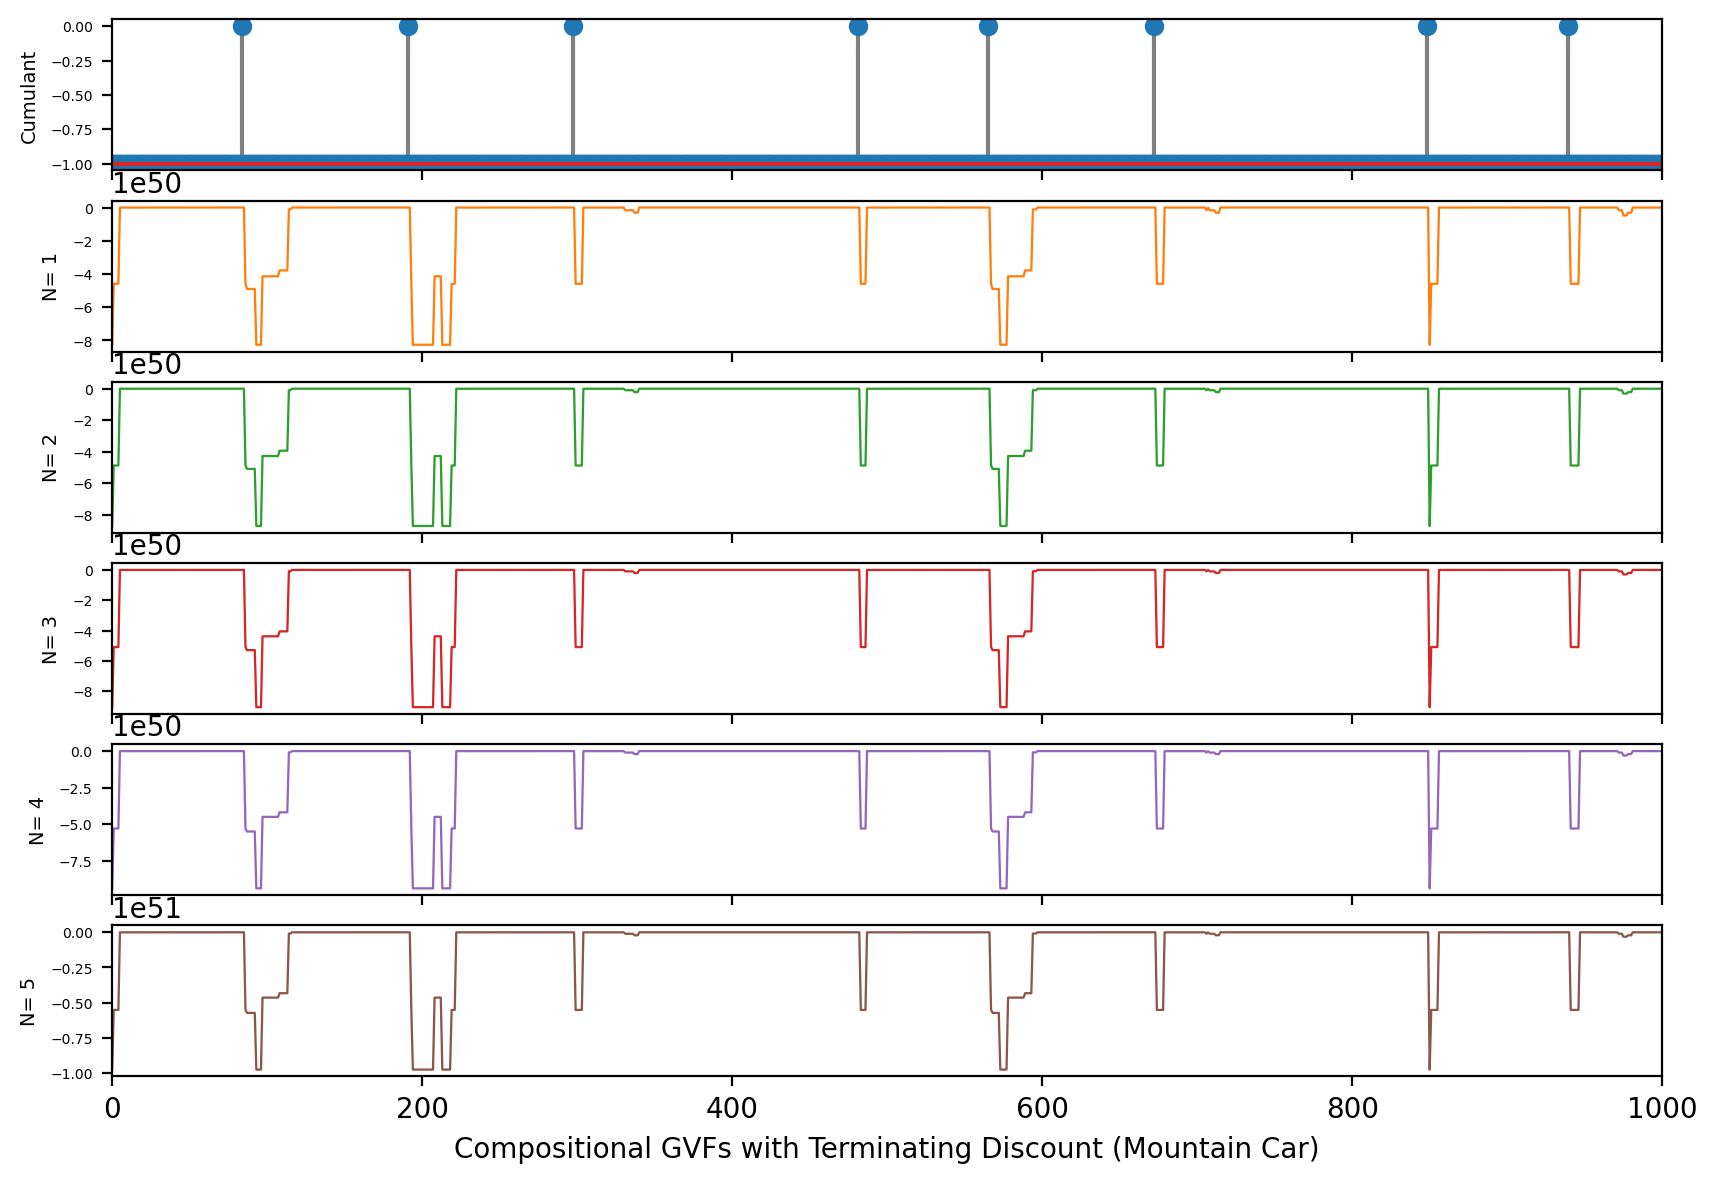

In [76]:
import matplotlib.pyplot as plt
#Return Plot
fig, axs = plt.subplots(n+1, figsize = (10, 7) ,dpi = 200, sharex=True)
plt.xlim(right = 1000, left = 0)
plt.xlabel('Compositional GVFs with Terminating Discount (Mountain Car)')

for k in range(n+1):
    if k == 0:
        axs[k].stem(time_step, cumulant, linefmt='grey', markerfmt='C0o', bottom=-1, use_line_collection=True)
        axs[k].set_ylabel('Cumulant', fontsize = 7)
        #axs[k].set(ylim=(0, 1.3))


    else:
        axs[k].plot(time_step, comp[k-1], color = colors[k], linewidth = 0.8193)
        axs[k].set_ylabel('N= ' + str(k), fontsize = 7)
    axs[k].tick_params(axis='y' , which='major', labelsize=5)
plt.savefig('MountainCarCompGVFsTerminating.png')

## Mountain Car Simulation

In [ ]:
env = MountainCarEnv("human")
mx = MountainCarFixed()
step_size = 1
env.action_space.seed(46)
g = 0.9
observation, info = env.reset(seed=46, return_info=True)
observation = tuple(observation)
action = 0
input_range = np.array(tuple(zip(env.observation_space.low, env.observation_space.high)))
tc = TileCoder(2,8, input_range, [7,7]) #8*8 Tiles
input_size = tc.total_tiles
step_size /= 8

for n in range(1000):
    observation, reward, done, info, _ = env.step(mx.predict(observation))
    if done:
        env.reset()
